# Image Captioning

#### This notebook represents the final version of my Deep Learning project for the Deep Learning course at ITS Academy Angelo Rizzoli.

The goal of the project was to build a model capable of generating captions for images. We imagined it as a tool that could be implemented in assistive technologies for blind or visually impaired individuals. Although we did not implement text-to-speech functionality, the model can generate textual descriptions of visual content, which could be integrated into applications that convert these descriptions into audio, allowing users to receive verbal information about their surroundings or other visual inputs. 

The notebooks contains all the necessary code to train a functioning neural network. Feel free to experiment with the hyperparameters — those used in this notebook are not optimized, and that’s intentional. With more training time and proper tuning, the results could be significantly improved.

This final architecture is based on:

    - torch framework
    - bert-base-uncased tokenizer
    - flickr dataset: https://www.kaggle.com/datasets/eeshawn/flickr30k
    - CLIP resnet50 cnn and preprocessor
    - pytorch lightning framework

Fin more information on the repo README.md

This neural network architecture is the result of collaborative work by myself and my teammates: **Bono Davide**, **Simone Lorenzo Pe**, and **Riccardo Sacchetti**.

**Marco Ferrarini**


In [1]:
!pip install pytorch-lightning
!pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.

In [2]:
import os
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models.feature_extraction import create_feature_extractor

import pytorch_lightning as pl
from pytorch_lightning.callbacks import (
    BaseFinetuning,
    ModelCheckpoint,
    EarlyStopping,
    LearningRateMonitor
)

from transformers import AutoTokenizer

from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

import clip


os.environ["PL_DISABLE_FORK"] = "1"
torch.autograd.set_detect_anomaly(True)

#uploading clip preprocessor
model_name = 'RN50'
_, CLIP_PREPROCESS = clip.load(model_name) 

100%|███████████████████████████████████████| 244M/244M [00:24<00:00, 10.5MiB/s]


In [3]:
class CustomFlickrDataset(Dataset):
    """classic dataset class to deal with this version of the flickr dataset: https://www.kaggle.com/datasets/eeshawn/flickr30k
    the dataset is structures as: 
        - folder of images (31.8k images)
        - csv file with captions (image_name,comment_number,comment), there are 5 captions for each image 
    This uses:
        - TokenizerWrapper based on bert model to apply tokenization 
        - CLIP preprocessor to apply the original CLIP preprocessing
    Args: csv_file (str): path to the csv file with image names and captions
          img_dir (str): path to the directory with images
          clip_preprocess (callable): preprocessing function for images, we are using CLIP's preprocessing
          tokenizer (callable): tokenizer function, we are using a wrapper around a bert tokenizer
          max_length (int): maximum length of the tokenized captions, default is 49
          flip (bool): whether to apply random horizontal flip to images, default is True
          
    Returns a dictionary with keys 'image', 'caption', and 'img_path"""

    def __init__(self, csv_file, img_dir, clip_preprocess, tokenizer=None, max_length=49, flip=True):
        self.data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.max_length = max_length

        if flip:
            self.clip_preprocess = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                clip_preprocess,
            ])
        else:
            self.clip_preprocess = clip_preprocess

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_name = row['image_name']
        caption = row['comment']

        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        image_processed = self.clip_preprocess(image)

        if self.tokenizer:
            input_ids, _ = self.tokenizer([caption])
            input_ids = input_ids.squeeze(0)
        else:
            raise ValueError("Tokenizer is required")

        return {
            "image": image_processed,
            "caption": input_ids,
            "img_path": img_path
            }

In [4]:
class FlickrDataModule(pl.LightningDataModule):
    """DataModule for the Flickr30k dataset, which handles the loading and splitting of the dataset into train, validation, and test sets
    Args:
        csv_file (str): path to the csv file with image names and captions
        img_dir (str): path to the directory with images
        tokenizer (callable): tokenizer function, we are using a wrapper around a bert tokenizer
        clip_preprocess (callable): preprocessing function for images, we are using CLIP's preprocessing
        batch_size (int): batch size for dataloaders, default is 32
        num_workers (int): number of workers for dataloaders, default is 4
        max_length (int): maximum length of the tokenized captions, default is 49
    
    """
    # inizializziamo i path, tokenizer batch size ecc...
    def __init__(self, csv_file, img_dir, tokenizer, clip_preprocess, batch_size=32, num_workers=4, max_length=49):
        super().__init__()
        self.csv_file = csv_file
        self.img_dir = img_dir
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.max_length = max_length
        self.clip_preprocess = clip_preprocess

    def setup(self, stage=None):
        #uploading the dataset using our custom dataset class
        full_dataset = CustomFlickrDataset(
            csv_file=self.csv_file,
            img_dir=self.img_dir,
            tokenizer=self.tokenizer,
            max_length=self.max_length,
            clip_preprocess = self.clip_preprocess
        )

        # split the dataset into train, validation, and test sets
        total_len = len(full_dataset)
        train_len = int(0.9 * total_len)
        val_len = int(0.05 * total_len)
        test_len = total_len - train_len - val_len

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_len, val_len, test_len],
            generator=torch.Generator().manual_seed(42)  # for reproducibility
        )

    def train_dataloader(self): 
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                          persistent_workers=True,  # keeps workers alive between epochs
                        pin_memory=True,  shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self): 
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                          persistent_workers=True,  # keeps workers alive between epochs
                        pin_memory=True, shuffle=False, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)

    def get_test_image_paths(self): # this function returns the paths of the images in the test set, after training we will use it to generate captions on test images
        return [self.test_dataset.dataset[i]["img_path"] for i in self.test_dataset.indices]

In [5]:
class TokenizerWrapper:
    """A wrapper around a tokenizer to handle special tokens and tokenization with padding and truncation.
    Args:
        model_name (str): name of the pre-trained tokenizer model, default is "bert-base-uncased"
        max_length (int): maximum length of the tokenized sequences, default is 49
    """
    def __init__(self, model_name="bert-base-uncased", max_length=49):
        # uploading the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_length = max_length

        # Define special tokens
        special_tokens = {"additional_special_tokens": ["<SOS>", "<EOS>"]}
        self.tokenizer.add_special_tokens(special_tokens)  # Aggiungili al vocabolario
        self.sos_token = "<SOS>"
        self.eos_token = "<EOS>"

        #  if the tokenizer does not have a pad token, we set it to "[PAD]"
        self.pad_token = self.tokenizer.pad_token or "[PAD]"

        # id of the special tokens
        self.sos_token_id = self.tokenizer.convert_tokens_to_ids(self.sos_token)
        self.eos_token_id = self.tokenizer.convert_tokens_to_ids(self.eos_token)
        self.pad_token_id = self.tokenizer.pad_token_id or 0

    def __call__(self, texts):
        # ezplicitly add <SOS> at the beginning and <EOS> at the end of each sentence
        processed_texts = [f"{self.sos_token} {text} {self.eos_token}" for text in texts]

        # tokenize the sentences with padding and truncation
        tokens = self.tokenizer(
            processed_texts,
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return tokens["input_ids"], tokens["attention_mask"]

    def vocab_size(self):
        # Returns the size of the vocabulary
        return len(self.tokenizer)

    def decode(self, token_ids):
        #  Detokenizes a sequence of token IDs into text
        return self.tokenizer.decode(token_ids, skipspecial_tokens=True)

    def decode_batch(self, batch_ids):
        # Detokenizes a batch of sequences of token IDs into text
        return [self.decode(ids) for ids in batch_ids]

In [6]:
class CNN_encoder (nn.Module):
    """CNN encoder based on CLIP's ResNet50 model, with an additional projection layer and batch normalization.
    Args:
        embedding_dim (int): dimension of the output embedding
    We upload the pre-trained ResNet model from CLIP and freeze its parameters.
    The model consists of:
        - a ResNet backbone (ResNet50) from CLIP
        - a projection layer to map the output features to the desired embedding dimension
        - a batch normalization layer to normalize the projected features

    """
    def __init__(self, embedding_dim):

        super(CNN_encoder, self).__init__()
        
        model_name = 'RN50'
        model, preprocess = clip.load(model_name)
        self.resnet = model.visual

        for param in self.resnet.parameters():
            param.requires_grad_(False)

        in_features = self.resnet.output_dim
        self.projection = nn.Linear(in_features, embedding_dim) 
        self.bn = nn.BatchNorm1d(embedding_dim) 

    # theese functions will be used in the finetuning process to freeze/unfreeze the parameters of the backbone
    def freeze(self):
        for param in self.resnet.parameters():
            param.requires_grad = False

    def unfreeze(self):
        for param in self.resnet.layer4.parameters():
            param.requires_grad = True

        for param in self.resnet.attnpool.parameters():
             param.requires_grad = True


    def forward(self, images):# the 'images' need to be already preprocessed
        image_features = self.resnet(images)

        image_features = image_features.float()

        projected_features = self.projection(image_features)

        bn_output = self.bn(projected_features)

        return bn_output

    def get_parameter_groups(self):
        """Restituisce i parametri del backbone e quelli nuovi separatamente."""
        backbone_params = self.resnet.parameters()
        new_params = list(self.projection.parameters()) + list(self.bn.parameters())
        return backbone_params, new_params

In [7]:
class Embedding_layer(nn.Module): # crea gli embedding per le sequenze di token delle didascalie
    """"Embedding layer that combines token embeddings and positional embeddings
    Args:
        sequence_length (int): length of the input sequences (number of tokens in the longest caption)
        vocab_size (int): size of the vocabulary (number of unique tokens)
        embed_dim (int): dimension of the embeddings (dimensionality)"""
    
    def __init__(self, sequence_length, vocab_size, embed_dim): 
        super(Embedding_layer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim) # token embedding
        self.positional_embedding = nn.Embedding(sequence_length, embed_dim) # positional embedding
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def forward(self, x):

        length = x.shape[1] # x is the list of tokens, so x.shape is the number of tokens in the sentence
        positional_indices = torch.arange(length,device=x.device).unsqueeze(0).expand_as(x)

        embedded_tokens = self.token_embedding(x)
        embedded_positions = self.positional_embedding(positional_indices)

        return embedded_tokens + embedded_positions # sum of the two embeddings (token and position)

In [8]:
class Decoder_block (nn.Module): # implementa un singolo blocco del transformer
    """Decoder block that implements a single transformer decoder layer with self-attention, cross-attention, and feed-forward network.
    We use:
    - self-attention to allow the decoder to attend to its own previous outputs
    - cross-attention to allow the decoder to attend to the encoder's output (image features)
    Args:
        embed_dim (int): dimension of the embeddings (dimensionality)
        num_heads (int): number of attention heads
        ff_dim (int): dimension of the feed-forward network
        dropout_rate (float): dropout rate for regularization"""
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(Decoder_block, self).__init__()
        self.self_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout_rate)
        self.cross_attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True, dropout=dropout_rate)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x, encoder_output): # x = embedded tokens, encoder_output = image features

        norm_x = self.norm1(x)
        seq_len = x.size(1)
        # the causal mask allows the decoder to see only the positions before itself
        causal_mask = torch.triu(torch.ones(seq_len, seq_len,  device=x.device, dtype=torch.bool), diagonal=1)
        attn_out = self.self_attention(norm_x, norm_x, norm_x, attn_mask = causal_mask)[0]
        x = x + self.dropout1(attn_out) # connessione residuale

        x_norm2 = self.norm2(x)
        encoder_output_reshaped = encoder_output.unsqueeze(1) # -> [batch, 1, embed_dim]

        cross_attn_out = self.cross_attention(x_norm2, encoder_output_reshaped, encoder_output_reshaped)[0]
        x = x + self.dropout2(cross_attn_out)

        x_norm3 = self.norm3(x)
        ff_out = self.feed_forward(x_norm3)
        x = x + self.dropout3(ff_out)

        return x

In [9]:
class Image_Captioning(pl.LightningModule):
    """Image Captioning model that combines the CNN_encoder with the Decoder_block
    This class combines:
        - CNN_encoder to extract image features
        - Embedding_layer to convert token IDs to embeddings
        - Decoder_block to generate captions from the image features and embeddings
    Args:
        embed_dim (int): dimension of the embeddings (dimensionality)
        num_heads (int): number of attention heads
        ff_dim (int): dimension of the feed-forward network
        num_layers (int): number of decoder layers
        dropout_rate (float): dropout rate for regularization
        vocab_size (int): size of the vocabulary (number of unique tokens)
        sequence_length (int): length of the input sequences (number of tokens in the longest caption)
        pad_idx (int): index of the padding token in the vocabulary, used to ignore padding in loss calculation
        learning_rate (float): learning rate for the optimizer, default is 1e-4

        """
    def __init__(self, embed_dim, num_heads, ff_dim, num_layers, dropout_rate,
                 vocab_size, sequence_length, pad_idx=0, learning_rate=1e-4, ):
        super(Image_Captioning, self).__init__()
        self.save_hyperparameters()

        #Encoder layers
        self.CNN = CNN_encoder(embedding_dim=embed_dim)

        # Embedding layer
        self.embedding = Embedding_layer(sequence_length, vocab_size, embed_dim)

        # Decoder layers
        self.decoder = nn.ModuleList([ Decoder_block(embed_dim, num_heads, ff_dim, dropout_rate)  for _ in range(num_layers) ])

        # Output layer
        self.fc_out = nn.Linear(embed_dim, vocab_size)

        # Loss function with label smoothing
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx, label_smoothing=0.1)

    def forward(self, images, captions):
        encoder_output = self.CNN(images)
        embedded_captions = self.embedding(captions)

        for layer in self.decoder:
            embedded_captions = layer(embedded_captions, encoder_output)

        logits = self.fc_out(embedded_captions)
        return logits

    def freeze_backbone(self):
        self.CNN.freeze()

    def unfreeze_backbone(self):
        self.CNN.unfreeze()

    def training_step(self, batch, batch_idx):
        images = batch["image"]
        captions = batch["caption"]
        # Teacher forcing: input captions are shifted by one position
        input_captions = captions[:, :-1]
        target_captions = captions[:, 1:]

        logits = self(images, input_captions)

        #calculate loss
        loss = self.loss_fn(logits.reshape(-1, logits.size(-1)),
                           target_captions.reshape(-1))

        # Calulate accuracy, the 'accuracy' is inteded to be used for monitoring the training process, 
        # The accuracy is calculated using a mask to ignore padding tokens
        preds = logits.argmax(dim=-1)
        mask = target_captions != self.hparams.pad_idx
        correct = (preds == target_captions) & mask
        accuracy = correct.sum().float() / mask.sum() if mask.sum() > 0 else 0.0

        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, batch_size=images.size(0) )
        self.log('train_accuracy', accuracy, on_step=True, on_epoch=True, prog_bar=True, batch_size=images.size(0))

        return loss


    def validation_step(self, batch, batch_idx):
        images = batch["image"]
        captions = batch["caption"]
        input_captions = captions[:, :-1]
        target_captions = captions[:, 1:]

        logits = self(images, input_captions)
        loss = self.loss_fn(logits.reshape(-1, logits.size(-1)),
                           target_captions.reshape(-1))

        preds = logits.argmax(dim=-1)
        mask = target_captions != self.hparams.pad_idx
        correct = (preds == target_captions) & mask
        accuracy = correct.sum().float() / mask.sum() if mask.sum() > 0 else 0.0

        self.log('val_loss', loss, on_epoch=True, prog_bar=True,batch_size=images.size(0))
        self.log('val_accuracy', accuracy, on_epoch=True, prog_bar=True, batch_size=images.size(0))

        return loss

    def test_step(self, batch, batch_idx):
        images = batch["image"]
        captions = batch["caption"]
        input_captions = captions[:, :-1]
        target_captions = captions[:, 1:]

        logits = self(images, input_captions)
        loss = self.loss_fn(logits.reshape(-1, logits.size(-1)), target_captions.reshape(-1))

        preds = logits.argmax(dim=-1)
        mask = target_captions != self.hparams.pad_idx
        correct = (preds == target_captions) & mask
        accuracy = correct.sum().float() / mask.sum() if mask.sum() > 0 else 0.0

        self.log('test_loss', loss, on_epoch=True, prog_bar=True, batch_size=images.size(0))
        self.log('test_accuracy', accuracy, on_epoch=True, prog_bar=True, batch_size=images.size(0))

        return {"loss": loss, "accuracy": accuracy}

    def configure_optimizers(self):
        head_params = [
            p for n, p in self.named_parameters()
            if not n.startswith("CNN.") and p.requires_grad
        ]

        optimizer = torch.optim.AdamW(head_params, lr=self.hparams.learning_rate, weight_decay=0.01, eps=1e-7)
        # the eps parameter is used to avoid division by zero in the AdamW optimizer, it's crucial for stability during the fine tuning of the backbone. 
        # Models like CLIP have a very small learning rate, so we need to use a small eps value to avoid numerical instability.

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=60, eta_min=1e-9)

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_loss"
            }
        }

In [10]:
class CustomFinetuneCallback(BaseFinetuning):
    """Custom finetuning callback that unfreezes the backbone of the model after a certain number of epochs.
    """
    def __init__(self, unfreeze_epoch=10, lr=1e-8):
        super().__init__()
        self.unfreeze_epoch = unfreeze_epoch
        self.lr = lr
        self._unfroze = False

    def freeze_before_training(self, pl_module):
        print("[🔒] Freezing at the start...")
        pl_module.CNN.freeze()

    def finetune_function(self, pl_module, current_epoch, optimizer, optimizer_idx=None):
        if current_epoch >= self.unfreeze_epoch and not self._unfroze:
            print(f"[🔓] Unfreezing backbone at epoch {current_epoch}")

            # using the function that unfreezes both layer4 and attnpool
            pl_module.CNN.unfreeze()

            # collect parameters of layer4 and attnpool
            params_to_add = [
                p for p in pl_module.CNN.resnet.layer4.parameters() if p.requires_grad
            ]
            params_to_add.extend(
                p for p in pl_module.CNN.resnet.attnpool.parameters() if p.requires_grad
            )

            # adding parameters of projection and batch normalization layers
            params_to_add.extend(
                p for n, p in pl_module.CNN.named_parameters()
                if (n.startswith("projection.") or n.startswith("bn.")) and p.requires_grad
            )

            optimizer.add_param_group({
                'params': params_to_add,
                'lr': self.lr
            })

            self._unfroze = True

            for i, group in enumerate(optimizer.param_groups):
                num_params_in_group = len(group['params'])
                print(f"[Optimizer Group {i}] lr = {group['lr']} ")

In [11]:
tokenizer = TokenizerWrapper(model_name="bert-base-uncased", max_length=49)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [12]:
lr_monitor = LearningRateMonitor(logging_interval='step')
FREEZE_LR = 1e-6   # LR for initial training (only decoder, etc.)
UNFREEZE_LR = 1e-8 # LR for fine-tuning the backbone (much lower)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=4,
    mode='min'
)

data_module = FlickrDataModule(
    csv_file='/kaggle/input/flickr30k/captions.txt',
    img_dir='/kaggle/input/flickr30k/flickr30k_images',
    clip_preprocess = CLIP_PREPROCESS,
    tokenizer=tokenizer,
    batch_size=64,
    max_length=49
)

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints/",
    filename="image-captioning_2006",
    save_top_k=1,
    monitor="val_loss",
    mode="min"
)

freeze_callback = CustomFinetuneCallback(unfreeze_epoch=3, lr=UNFREEZE_LR)

model = Image_Captioning(
    embed_dim=1024,
    num_heads=8,
    ff_dim=4096,
    num_layers=4,
    dropout_rate=0.44,
    vocab_size=tokenizer.vocab_size(), 
    sequence_length=49,
    pad_idx=tokenizer.pad_token_id,
    learning_rate=FREEZE_LR,  
)

In [13]:
trainer = pl.Trainer(
    accelerator="gpu",
    devices='auto',
    strategy="auto",
    max_epochs=6,
    gradient_clip_val=0.1,

    callbacks=[checkpoint_callback, early_stop, lr_monitor, freeze_callback])

In [ ]:
trainer.fit(model, datamodule=data_module)

In [15]:
trainer.test(model, datamodule=data_module)

2025-07-28 15:06:25.784753: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753715185.962446      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753715186.015186      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[🔒] Freezing at the start...


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5428378582000732     │
│         test_loss         │     3.347947597503662     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.347947597503662, 'test_accuracy': 0.5428378582000732}]

In [ ]:
path_modello = "path/to/save/model.ckpt"  # specify the path where you want to save the model
trainer.save_checkpoint(path_modello)

In [14]:
# uploading a  model from the checkpoint
model = Image_Captioning.load_from_checkpoint("/kaggle/input/model-ventisettegiugno/modello_2806_10_epochs.ckpt")  # specify the path where you saved the model

In [136]:
@torch.no_grad()
def generate_caption(model, image_path, tokenizer, device='cuda', max_len=49):
    """This function serves the need to generate captions for images using the trained model.
    Args:
        model (Image_Captioning): trained image captioning model
        image_path (str): path to the image for which to generate a caption
        tokenizer (TokenizerWrapper): tokenizer to convert captions to token IDs
        device (str): device to run the model on, default is 'cuda'
        max_len (int): maximum length of the generated caption, default is 49"""
    model.eval()
    model.to(device)

    # Preprocess the image using CLIP's preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)

    # Extract image features using the CNN encoder
    encoder_output = model.CNN(image)  # shape: (1, visual_embedding_dim)

    sos_idx = tokenizer.sos_token_id
    eos_idx = tokenizer.eos_token_id

    caption = [sos_idx]

    for _ in range(max_len):
        input_tensor = torch.tensor(caption, dtype=torch.long).unsqueeze(0).to(device)
        embedded = model.embedding(input_tensor)  # shape: (1, seq_len, embedding_dim)

        for layer in model.decoder:
            embedded = layer(embedded, encoder_output)

        output = model.fc_out(embedded)  # shape: (1, seq_len, vocab_size)
        next_token = output[:, -1, :].argmax(dim=-1).item()
        caption.append(next_token)

        if next_token == eos_idx:
            break

    #Decoding the caption to a human-readable format
    sentence = tokenizer.decode(caption)
    return sentence

In [16]:
# extracting the paths of the images in the test set
test_image_paths = data_module.get_test_image_paths()

In [18]:
def show_image(image_path, title=None):
    """Mostra un'immagine a partire dal path"""
    image = Image.open(image_path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

image: /kaggle/input/flickr30k/flickr30k_images/7368081478.jpg
generated caption: <SOS> a young man in a black wetsuit surfs on a surfboard. <EOS>


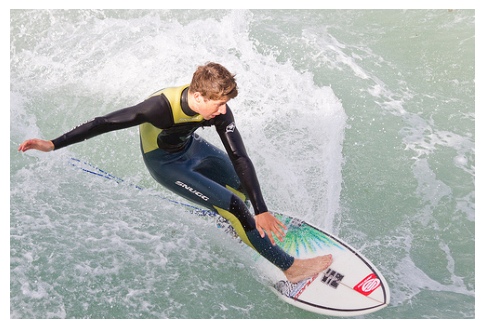

In [221]:
import random
image_path = random.choice(test_image_paths)

caption = generate_caption(
    model=model,
    image_path=image_path,
    tokenizer=tokenizer,
    device='cuda'
)

print("image:", image_path)
print("generated caption:", caption)

show_image(image_path)